<h3><b>VIDEO RATINGS ANALYSIS</b></h3>
<p>Takes the video ratings scores for the three outcomes (fear, disgust and points) at two timepoints (for fear and disgust:only one rating for points)</p>
<p>Carries out the checks using mixed effects models, as specified in the analysis plan (as well as detailing what is expected from these checks)</p>
<br>
<p>NB this current version is run on fake data - randomly generated (so won't see any expected effects)

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import jsonlines
from functools import reduce
import statistics
import scipy.stats
import seaborn as sns
import math
import os
import json
import ast
import matplotlib.patches as mpatches
import statsmodels.api as sm
import statsmodels.formula.api as smf
from numpy import std, mean, sqrt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.copy_on_write = True

In [62]:
chosen_stim_df = pd.read_csv("csvs/chosen_stim_dummy.csv")
chosen_stim_df.drop('Unnamed: 0', axis="columns", inplace=True)

In [63]:
#create long form df which allows for this
long_chosen_stim_df=pd.DataFrame()
for i in chosen_stim_df.index:
    row=chosen_stim_df.loc[i]
    #timepoint=['unpleasan']
    timepoint_1=pd.DataFrame({
    'participant_no': [row.participant_no],
    'Vid': [row['Vid']],
    'trial_type': [row.trial_type],
    'Valence': [row.unpleasant_1],
    'Arousal': [row.arousing_1],
    'Fear': [row.frightening_1],
    'Disgust': [row.disgusting_1],
    'Timepoint': 1.0
    })
    timepoint_2=pd.DataFrame({
        'participant_no': [row.participant_no],
        'Vid': [row['Vid']],
        'trial_type': [row.trial_type],
        'Valence': [row.unpleasant_2],
        'Arousal': [row.arousing_2],
        'Fear': [row.frightening_2],
        'Disgust': [row.disgusting_2],
        'Timepoint': 2.0
    })
    long_chosen_stim_df_row=pd.concat([timepoint_1, timepoint_2])
    long_chosen_stim_df=pd.concat([long_chosen_stim_df_row, long_chosen_stim_df])
    long_chosen_stim_df=long_chosen_stim_df[long_chosen_stim_df.trial_type!="points"]

<b>1. ANALYSING THE CHOSEN STIMULI (Fear and disgust)</b>
<p> Doing this using 4 mixed effects models - testing effect of timepoint and stimulus type on ratings </p>
<p>List of models to run:
<li> A) 'Valence ~ trial_type*Timepoint'
<li> B) 'Arousal ~ trial_type*Timepoint'
<li> C) 'Disgust ~ trial_type*Timepoint'
<li> D) 'Fear ~ trial_type*Timepoint'

In [64]:
##mixed effects model Valence
data=long_chosen_stim_df.reset_index()
data.replace(['disgust', 'fear'], [1.0,2.0], inplace=True)
formula = 'Valence ~ trial_type*Timepoint'
md=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
results = md.fit()
print(results.summary())

             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   Valence  
No. Observations:     56        Method:               REML     
No. Groups:           14        Scale:                4.9011   
Min. group size:      4         Log-Likelihood:       -121.5227
Max. group size:      4         Converged:            Yes      
Mean group size:      4.0                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             4.500    2.961  1.520 0.129 -1.304 10.304
trial_type           -1.786    1.871 -0.954 0.340 -5.453  1.881
Timepoint            -0.571    1.871 -0.305 0.760 -4.239  3.096
trial_type:Timepoint  1.286    1.183  1.087 0.277 -1.034  3.605
Group Var             0.233    0.298                           



In [65]:
##mixed effects model Arousal
data=long_chosen_stim_df.reset_index()
data.replace(['disgust', 'fear'], [1.0,2.0], inplace=True)
formula = 'Arousal ~ trial_type*Timepoint'
md=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
results = md.fit()
print(results.summary())

             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   Arousal  
No. Observations:     56        Method:               REML     
No. Groups:           14        Scale:                6.1058   
Min. group size:      4         Log-Likelihood:       -128.4612
Max. group size:      4         Converged:            Yes      
Mean group size:      4.0                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             7.071    3.309  2.137 0.033  0.586 13.557
trial_type           -1.000    2.088 -0.479 0.632 -5.093  3.093
Timepoint            -0.786    2.088 -0.376 0.707 -4.879  3.307
trial_type:Timepoint  0.071    1.321  0.054 0.957 -2.517  2.660
Group Var             0.668    0.402                           



In [66]:
##mixed effects model Fear
data=long_chosen_stim_df.reset_index()
data.replace(['disgust', 'fear'], [1.0,2.0], inplace=True)
formula = 'Fear ~ trial_type*Timepoint'
md=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
results = md.fit()
print(results.summary())

             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   Fear     
No. Observations:     56        Method:               REML     
No. Groups:           14        Scale:                6.0623   
Min. group size:      4         Log-Likelihood:       -127.9308
Max. group size:      4         Converged:            Yes      
Mean group size:      4.0                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             2.286    3.296  0.693 0.488 -4.175  8.746
trial_type            1.357    2.081  0.652 0.514 -2.721  5.436
Timepoint             1.143    2.081  0.549 0.583 -2.936  5.221
trial_type:Timepoint -1.000    1.316 -0.760 0.447 -3.579  1.579
Group Var             0.550    0.380                           



In [67]:
##mixed effects model Disgust
data=long_chosen_stim_df.reset_index()
data.replace(['disgust', 'fear'], [1.0,2.0], inplace=True)
formula = 'Disgust ~ trial_type*Timepoint'
md=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
results = md.fit()
print(results.summary())

             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   Disgust  
No. Observations:     56        Method:               REML     
No. Groups:           14        Scale:                7.3787   
Min. group size:      4         Log-Likelihood:       -131.5261
Max. group size:      4         Converged:            Yes      
Mean group size:      4.0                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             3.071    3.631  0.846 0.398 -4.046 10.189
trial_type            0.429    2.296  0.187 0.852 -4.071  4.928
Timepoint            -0.286    2.296 -0.124 0.901 -4.785  4.214
trial_type:Timepoint  0.071    1.452  0.049 0.961 -2.774  2.917
Group Var             0.147    0.332                           



<b>Interpretation of these models:</b>
<li>Expect matched valence and arousal across fear and disgusting video types (A+B)
<li>Expect differences in fear and disgust ratings across video types (C+D)
<li>Expect some habituation of ratings (an effect of time) (A,B,C,D)
<li> Might be different habituation between fear and disgust (fear*time interaction) (A,B,C,D)
<br>
<p>Followup analyses in main hypothesis testing required:</p>
<li>If there is a difference in valence and arousal across fear and disgusting videos: add this difference as a covariate (fear(T1)-disgust(T1))
<li>If there is a difference in habituation between fear and disgusting videos: add this difference in habituation as a covariate (Fear(T2-T1) - Disgust(T2-T1))

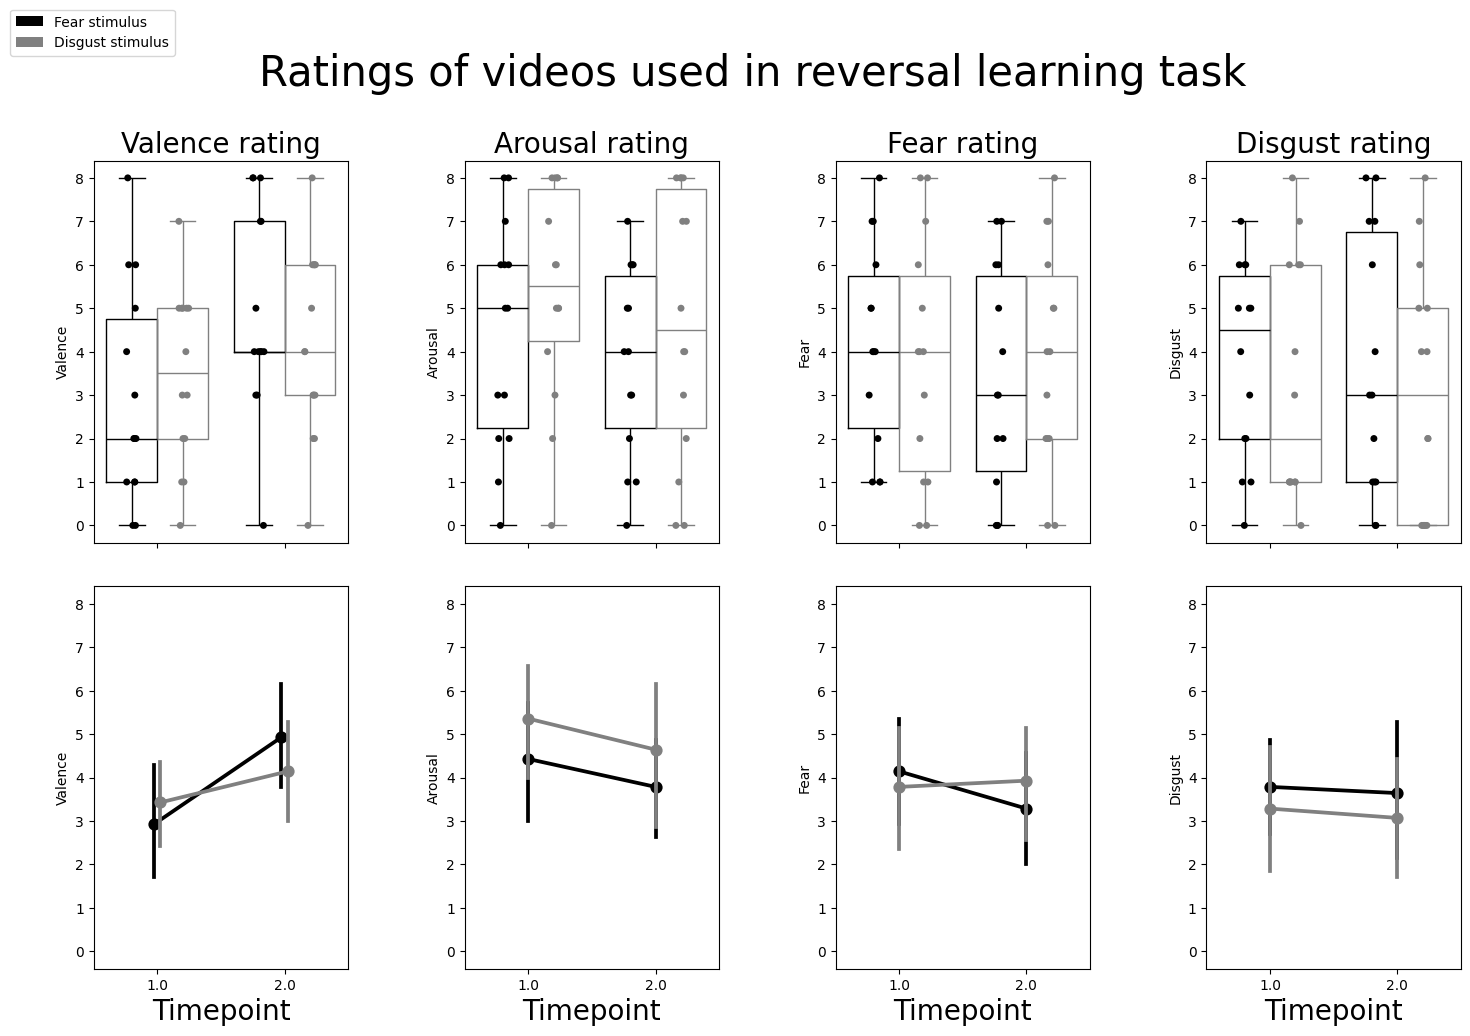

In [68]:
#example plot
fig, axes = plt.subplots(2,4, sharex='col', sharey='col')
title="Ratings of videos used in reversal learning task"
plt.suptitle(title, fontsize=30)
fig.tight_layout(pad=0.5)
fig.set_size_inches(15, 10)

palette = {'fear': '0',
            'disgust': '0.5'}
sns.stripplot(data=long_chosen_stim_df, ax=axes[0,0], x='Timepoint', y='Valence', hue='trial_type', dodge=True, palette=palette)
sns.boxplot(data=long_chosen_stim_df, ax=axes[0,0], x='Timepoint', y='Valence', hue='trial_type', fill=False, palette=palette, linewidth=1)
axes[0,0].get_legend().set_visible(False)
axes[0,0].set_title("Valence rating", fontsize=20) 

sns.pointplot(data=long_chosen_stim_df, ax=axes[1,0], x='Timepoint', y='Valence', hue='trial_type', dodge=True, palette=palette)
axes[1,0].get_legend().set_visible(False)
axes[1,0].xaxis.get_label().set_fontsize(20)

sns.stripplot(data=long_chosen_stim_df, ax=axes[0,1], x='Timepoint', y='Arousal', hue='trial_type', dodge=True, palette=palette)
sns.boxplot(data=long_chosen_stim_df, ax=axes[0,1], x='Timepoint', y='Arousal', hue='trial_type', fill=False, palette=palette, linewidth=1)
axes[0,1].get_legend().set_visible(False)
axes[0,1].set_title("Arousal rating", fontsize=20) 

sns.pointplot(data=long_chosen_stim_df, ax=axes[1,1], x='Timepoint', y='Arousal', hue='trial_type', dodge=False, palette=palette)
axes[1,1].get_legend().set_visible(False)
axes[1,1].xaxis.get_label().set_fontsize(20)

sns.stripplot(data=long_chosen_stim_df, ax=axes[0,2], x='Timepoint', y='Fear', hue='trial_type', dodge=True, palette=palette)
sns.boxplot(data=long_chosen_stim_df, ax=axes[0,2], x='Timepoint', y='Fear', hue='trial_type', fill=False, palette=palette, linewidth=1)
axes[0,2].get_legend().set_visible(False)
axes[0,2].set_title("Fear rating", fontsize=20) 

sns.pointplot(data=long_chosen_stim_df, ax=axes[1,2], x='Timepoint', y='Fear', hue='trial_type', dodge=False, palette=palette)
axes[1,2].get_legend().set_visible(False)
axes[1,2].xaxis.get_label().set_fontsize(20)

sns.stripplot(data=long_chosen_stim_df, ax=axes[0,3], x='Timepoint', y='Disgust', hue='trial_type', dodge=True, palette=palette)
sns.boxplot(data=long_chosen_stim_df, ax=axes[0,3], x='Timepoint', y='Disgust', hue='trial_type', fill=False, palette=palette, linewidth=1)
axes[0,3].get_legend().set_visible(False)
axes[0,3].set_title("Disgust rating", fontsize=20) 

sns.pointplot(data=long_chosen_stim_df, ax=axes[1,3], x='Timepoint', y='Disgust', hue='trial_type', dodge=False, palette=palette)
axes[1,3].get_legend().set_visible(False)
axes[1,3].xaxis.get_label().set_fontsize(20)

plt.figlegend(loc='center left', bbox_to_anchor=(0,1),  handles=[mpatches.Patch(facecolor='0'), mpatches.Patch(facecolor='0.5')], labels=['Fear stimulus', 'Disgust stimulus'])
plt.show()

<b>2. CHECK POINTS RATINGS</b>
<p>Aim: check whether points block differs from other blocks in terms of ratings (at T1) - a sanity check</p>
<p>List of models to run: </p>
<li>'disgusting_1 ~ trial_type'
<li>'frightening_1 ~ trial_type'
<li>'unpleasant_1 ~ trial_type'
<li>'arousing_1 ~ trial_type'

In [69]:
data=chosen_stim_df[['participant_no', 'trial_type', 'unpleasant_1', 'arousing_1', 'disgusting_1', 'frightening_1']]
data.replace(['disgust', 'fear', 'points'], [1.0,2.0, 3.0], inplace=True)
formula = 'disgusting_1 ~ trial_type'
md=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
results = md.fit()
print(results.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: disgusting_1
No. Observations: 42      Method:             REML        
No. Groups:       14      Scale:              5.9562      
Min. group size:  3       Log-Likelihood:     -95.9813    
Max. group size:  3       Converged:          Yes         
Mean group size:  3.0                                     
-----------------------------------------------------------
            Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept    3.500     0.996   3.513  0.000   1.547   5.453
trial_type  -0.036     0.461  -0.077  0.938  -0.940   0.868
Group Var    0.000     0.436                               



U:\Documents\envs\reversal_learning_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
U:\Documents\envs\reversal_learning_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [70]:
data=chosen_stim_df[['participant_no', 'trial_type', 'unpleasant_1', 'arousing_1', 'disgusting_1', 'frightening_1']]
data.replace(['disgust', 'fear', 'points'], [1.0,2.0, 3.0], inplace=True)
formula = 'frightening_1 ~ trial_type'
md=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
results = md.fit()
print(results.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: frightening_1
No. Observations: 42      Method:             REML         
No. Groups:       14      Scale:              6.4092       
Min. group size:  3       Log-Likelihood:     -97.4472     
Max. group size:  3       Converged:          Yes          
Mean group size:  3.0                                      
------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept     4.238     1.034   4.101  0.000   2.212   6.264
trial_type   -0.250     0.478  -0.523  0.601  -1.188   0.688
Group Var     0.000     0.896                               



U:\Documents\envs\reversal_learning_venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
U:\Documents\envs\reversal_learning_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
U:\Documents\envs\reversal_learning_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
U:\Documents\envs\reversal_learning_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [71]:
data=chosen_stim_df[['participant_no', 'trial_type', 'unpleasant_1', 'arousing_1', 'disgusting_1', 'frightening_1']]
data.replace(['disgust', 'fear', 'points'], [1.0,2.0, 3.0], inplace=True)
formula = 'unpleasant_1 ~ trial_type'
md=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
results = md.fit()
print(results.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: unpleasant_1
No. Observations: 42      Method:             REML        
No. Groups:       14      Scale:              5.1733      
Min. group size:  3       Log-Likelihood:     -95.6978    
Max. group size:  3       Converged:          Yes         
Mean group size:  3.0                                     
-----------------------------------------------------------
              Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept     3.119     0.960  3.250  0.001   1.238   5.000
trial_type    0.107     0.430  0.249  0.803  -0.735   0.950
Group Var     0.823     0.535                              



In [72]:
data=chosen_stim_df[['participant_no', 'trial_type', 'unpleasant_1', 'arousing_1', 'disgusting_1', 'frightening_1']]
data.replace(['disgust', 'fear', 'points'], [1.0,2.0, 3.0], inplace=True)
formula = 'arousing_1 ~ trial_type'
md=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
results = md.fit()
print(results.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: arousing_1
No. Observations: 42      Method:             REML      
No. Groups:       14      Scale:              5.9726    
Min. group size:  3       Log-Likelihood:     -96.0362  
Max. group size:  3       Converged:          Yes       
Mean group size:  3.0                                   
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      5.524    0.998  5.536 0.000  3.568  7.479
trial_type    -0.357    0.462 -0.773 0.439 -1.262  0.548
Group Var      0.000    0.470                           



U:\Documents\envs\reversal_learning_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
U:\Documents\envs\reversal_learning_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<b>Interpretation of these models:</b>
<li>Expect points to differ from fear vs disgust in all 4 models (an effect of feedback type in all 4 models)

Text(258.7682291666667, 0.5, 'Fear')

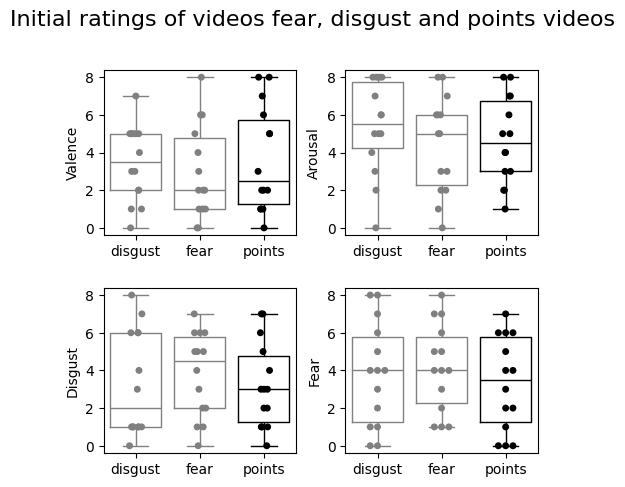

In [73]:
#example plot for this data
data=chosen_stim_df[['participant_no', 'trial_type', 'unpleasant_1', 'arousing_1', 'disgusting_1', 'frightening_1']].sort_values('trial_type')
fig, axes = plt.subplots(2,2)
title="Initial ratings of videos fear, disgust and points videos"
plt.suptitle(title, fontsize=16)
fig.tight_layout(pad=1.5)
fig.set_size_inches(5, 5)

order=['fear', 'disgust', 'points']
palette = {'fear': '0.5',
            'disgust': '0.5',
            'points': '0'}
sns.boxplot(data=data, ax=axes[0,0],   x='trial_type', hue='trial_type', y='unpleasant_1', palette=palette, legend=False, fill=False, linewidth=1, hue_order=order)
sns.stripplot(data=data, ax=axes[0,0],  x='trial_type', hue='trial_type', y='unpleasant_1', palette=palette, legend=False, dodge=False, hue_order=order)
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('Valence')

sns.boxplot(data=data, ax=axes[0,1], x='trial_type', hue='trial_type', y='arousing_1', palette=palette, legend=False, fill=False, linewidth=1, hue_order=order)
sns.stripplot(data=data, ax=axes[0,1], x='trial_type', hue='trial_type', y='arousing_1', palette=palette, legend=False, dodge=False, hue_order=order)
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('Arousal')

sns.boxplot(data=data, ax=axes[1,0], x='trial_type', hue='trial_type', y='disgusting_1', palette=palette, legend=False, fill=False, linewidth=1, hue_order=order)
sns.stripplot(data=data, ax=axes[1,0], x='trial_type', hue='trial_type', y='disgusting_1', palette=palette, legend=False, dodge=False, hue_order=order)
axes[1,0].set_xlabel('')
axes[1,0].set_ylabel('Disgust')

sns.boxplot(data=data, ax=axes[1,1], x='trial_type',  hue='trial_type', y='frightening_1', palette=palette, legend=False, fill=False, linewidth=1, hue_order=order)
sns.swarmplot(data=data, ax=axes[1,1], x='trial_type',  hue='trial_type',  y='frightening_1', palette=palette, legend=False, dodge=False, hue_order=order)
axes[1,1].set_xlabel('')
axes[1,1].set_ylabel('Fear')